# Plots of Average BT Histograms

Here, we plot BT Histograms that are gathered for different pre-defined regions and the full domain.

In [1]:
%matplotlib inline

import glob, os
import numpy as np
import pylab as pl
import seaborn as sns
sns.set_context('talk')
import xarray as xr
import datetime


pl.rcParams['figure.figsize'] = (16.0, 12.0)
pl.rcParams['font.size'] = 16.0
pl.rcParams['axes.labelpad'] = 12

In [2]:

from tropy.standard_config import local_data_path


## Input

### Make a Filelist

In [3]:
# version = 'v2019-10-18'
# version = 'v2020-02-13'
version = 'v2020-06-08'


In [4]:
# new path
fdir = '%s/icon/stoch_exp_%s' % ( local_data_path, version )

In [5]:
flist = sorted( glob.glob( '%s/bt*-hdcp2_atlantic*nc' % fdir) )

In [6]:
for i, fname in enumerate( flist ):
    print(i, fname )

(0, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_msevi-hdcp2_atlantic-20131220.nc')
(1, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_detconv.nc')
(2, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_detconv_nolim_notundepth.nc')
(3, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_noconv.nc')
(4, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc')
(5, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_stochconv_vervel_-00.nc')


### Sort Exp a bit

In [7]:
if version == 'v2019-10-18':
    ilist = [0, 2, 1, 5, 6 ]
elif version == 'v2020-02-13':
    ilist = [0, 2, 1, 3, 4]
elif version == 'v2020-06-08':
#    ilist = [0, 3, 2, 4]
    ilist = [0, 3, 1, 4]
   
sorted_fnames = np.array(flist )[ilist]

In [8]:
if version == 'v2020-06-08':
#     labels = ['SEVIRI', 'NOCONV', 'D-NOMFL', 'S-NOMFL']
    labels = ['SEVIRI', 'NOCONV', 'D-OPER', 'S-NOMFL']

else:
    labels = ['SEVIRI', 'NOCONV', 'D-OPER', 'S-DFLT', 'S-CPLN']

In [9]:
labelmap = {}
for i, fname in enumerate( sorted_fnames ):
    labelmap[fname] = labels[i]
    
    print( '%s %s' % (labels[i], fname))

SEVIRI /vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_msevi-hdcp2_atlantic-20131220.nc
NOCONV /vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_noconv.nc
D-OPER /vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_detconv.nc
S-NOMFL /vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/bt-hists_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc


### Read Data 

In [10]:
dlist = []

for fname in labelmap.keys():
    label = labelmap[fname]
    d = xr.open_dataset( fname )
    
    d.expand_dims( 'idname' )
    d['idname'] = [label,]
    
    dlist += [d, ]

In [11]:
dset = xr.concat( dlist, dim = 'idname' )

## Prepare Variables 

### Get Rid of Spinup

Let's say we consider the the six hours as spinup.

In [12]:
time_range = slice( '2013-12-20T06', '2013-12-20')

In [13]:
bthist = dset.sel( time = time_range )
bthist.mean('time')

<xarray.Dataset>
Dimensions:    (bin_edges: 100, bin_mids: 99, idname: 4, region: 3)
Coordinates:
  * region     (region) |S19 'Full' 'Northern_Subtropics' 'Southern_Subtropics'
  * bin_edges  (bin_edges) float64 200.0 201.1 202.2 203.3 ... 307.8 308.9 310.0
  * bin_mids   (bin_mids) float64 200.6 201.7 202.8 203.9 ... 307.2 308.3 309.4
  * idname     (idname) object 'D-OPER' 'NOCONV' 'SEVIRI' 'S-NOMFL'
Data variables:
    counts     (idname, region, bin_mids) float64 13.72 17.39 22.72 ... 0.0 0.0

### Calculate PDFs

In [14]:
dT = bthist.bin_edges.diff('bin_edges')
#dT = dT.rename({'bin_edges': 'bin_mids'})

c = bthist.counts
csum = c.sum('bin_mids')



In [15]:
bthist['bin_width'] = xr.DataArray( data = dT.data, dims = ('bin_mids'))
bthist['pdf'] = bthist['counts'] / (bthist['bin_width'] * csum)

In [16]:
bthist

<xarray.Dataset>
Dimensions:    (bin_edges: 100, bin_mids: 99, idname: 4, region: 3, time: 18)
Coordinates:
  * bin_mids   (bin_mids) float64 200.6 201.7 202.8 203.9 ... 307.2 308.3 309.4
  * time       (time) datetime64[ns] 2013-12-20T06:00:00 ... 2013-12-20T23:00:00
  * region     (region) |S19 'Full' 'Northern_Subtropics' 'Southern_Subtropics'
  * bin_edges  (bin_edges) float64 200.0 201.1 202.2 203.3 ... 307.8 308.9 310.0
  * idname     (idname) object 'D-OPER' 'NOCONV' 'SEVIRI' 'S-NOMFL'
Data variables:
    counts     (idname, region, time, bin_mids) float64 10.0 10.0 ... 0.0 0.0
    bin_width  (bin_mids) float64 1.111 1.111 1.111 1.111 ... 1.111 1.111 1.111
    pdf        (idname, region, time, bin_mids) float64 6.882e-06 ... 0.0

In [17]:
# proof
( bthist['pdf'] * bthist['bin_width']).sum('bin_mids')

<xarray.DataArray (idname: 4, region: 3, time: 18)>
array([[[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-12-20T06:00:00 ... 2013-12-20T23:00:00
  * region   (region) |S19 'Full' 'Northern_Subtropics' 'Southern_Subtropics'
  * idname   (idname) object 'D-OPER' 'NOCONV' 'SEVIRI' 'S-NOMFL'

## Plotting

### Color Scheme

In [18]:
def get_exp_kws( expname, **kwargs ):
    
    ptype = kwargs.get('ptype', 'points')
    
    kws = {}
#    labels = ('NOCONV','D-OPER','S-DFLT','S-CPLN')
#    cols = ('#0000FF', '#008000',  '#FF0000', '#FFA500',)
    
    labels = ('NOCONV', 'D-OPER', 'S-NOMFL' )
    cols = ('#0000FF', '#008000',  '#FF0000', )#'#FFA500',)
    #cols = [(0.0, 0.0, 1.0), (0.0, 0.5019607843137255, 0.0), 
    #        (1.0, 0.6470588235294118, 0.0), (1.0, 0.0, 0.0)]
    
    for i, lab in enumerate( labels ):
        if expname == lab:
            kws['color'] = cols[i]

    if expname == 'SEVIRI':
        kws['color'] = 'black'
    
    if ptype == 'points' and expname == 'SEVIRI':
        kws['marker'] = 'D'
        kws['zorder'] = 10
        kws['markersize'] = 10
    elif ptype == 'points':
        kws['marker'] = 'o'
        kws['zorder'] = 8
        kws['markersize'] = 8
            
    elif ptype == 'lines':
        kws['lw'] = 3

    return kws



### Legend

In [19]:
def plegend(bbox = (1.5, 0.5)):
    handles, labels = pl.gca().get_legend_handles_labels()

    # put msevi on top
    order = range(len(labels))
    mindex = labels.index( 'SEVIRI')
    order.remove(mindex)
    order = [mindex,] + order

    pl.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          loc='center right', bbox_to_anchor = bbox, fontsize = 'large', frameon = False )

In [20]:
bthist.region

<xarray.DataArray 'region' (region: 3)>
array(['Full', 'Northern_Subtropics', 'Southern_Subtropics'], dtype='|S19')
Coordinates:
  * region   (region) |S19 'Full' 'Northern_Subtropics' 'Southern_Subtropics'

### Full Histograms - Cold Clouds

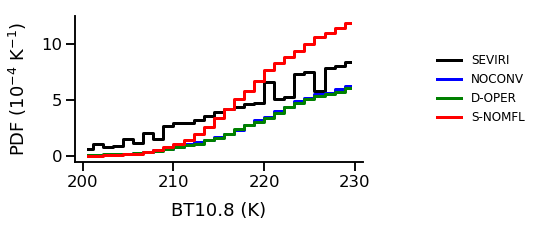

In [21]:
pl.figure( figsize = (8,3.5))

bkw = dict( bin_mids = slice(200,230))
    

for lab in labels:
    kws = get_exp_kws(lab, ptype = 'lines')
    sel = dict( region = 'Full', idname = lab,  )
    
    pl.step( bthist.bin_mids.sel( **bkw), 1e4 * bthist.pdf.mean( 'time' ).sel(**bkw).sel(**sel),
             label = lab, where = 'mid',**kws)
    
pl.xlabel('BT10.8 (K)')
pl.ylabel('PDF ($10^{-4}$ K${}^{-1}$)')
plegend( bbox = (1.6, 0.5) )
sns.despine()
pl.subplots_adjust( right = 0.7, bottom = 0.3, left = 0.2)

pl.savefig('../pics/daily-average-bt108-hist_range200-230K_%s.jpg' % version, dpi = 300)


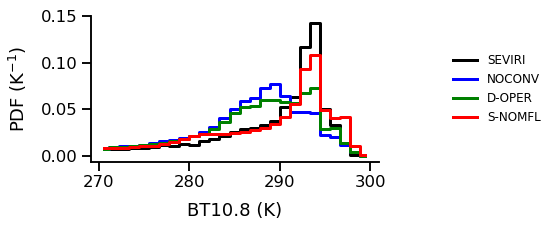

In [22]:
pl.figure( figsize = (8,3.5))

bkw = dict( bin_mids = slice(270,300))
    

for lab in labels:
    kws = get_exp_kws(lab, ptype = 'lines')
    sel = dict( region = 'Full', idname = lab,  )
    
    pl.step( bthist.bin_mids.sel( **bkw), bthist.pdf.mean( 'time' ).sel(**bkw).sel(**sel),
             label = lab, where = 'mid',**kws)
    
pl.xlabel('BT10.8 (K)')
pl.ylabel('PDF (K${}^{-1}$)')
plegend(bbox = (1.6, 0.5))
sns.despine()
pl.subplots_adjust( right = 0.7, bottom = 0.3, left = 0.2)

pl.savefig('../pics/daily-average-bt108-hist_range270-300K_%s.jpg' % version, dpi = 300)
